In [1]:
# Set environment variables
import os
os.environ['FSLDIR'] = '/usr/local/fsl'
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['FSLMULTIFILEQUIT'] = 'TRUE'
os.environ['FSLTCLSH'] = os.path.join(os.getenv('FSLDIR', ''), 'bin/fsltclsh')
os.environ['FSLWISH'] = os.path.join(os.getenv('FSLDIR', ''), 'bin/fslwish')
os.environ['FSL_LOAD_NIFTI_EXTENSIONS'] = '0'
os.environ['FSL_SKIP_GLOBAL'] = '0'
os.environ['PATH'] = os.path.join(os.getenv('FSLDIR', ''), 'bin') + ':' + os.environ['PATH']

In [2]:
# Test if FSL command is available
import subprocess
subprocess.run(['flirt', '-version'], check=True)

FLIRT version 6.0


CompletedProcess(args=['flirt', '-version'], returncode=0)

In [3]:
!flirt -version

FLIRT version 6.0


### Import all necessary Library

In [4]:
import nibabel as nib
from nilearn.plotting import plot_anat, plot_img
from nilearn.image import index_img

import fsl
from fsl.data.melodicanalysis import getComponentPowerSpectra, getComponentTimeSeries
from fsl.wrappers import bet, flirt, fslmaths, mcflirt, fslroi, fslmerge, topup, applytopup, melodic

import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
import ipywidgets as widgets
from IPython.display import Image, display

#### Test FSL and Nibabel with MRI(FLAIR) Nifti file

In [3]:
# PLOT the MRI
def plot_brain_3D(file_path, slider_name1='Orientation', slider_name2='Slice'):

    # Load MRI images
    brain_img = nib.load(file_path)
    brain_data = brain_img.get_fdata()

    # Function for showing each slice of MRI
    def plot_slice(axis, slice_idx):
        plt.figure(figsize=(10, 10))
        if axis == 0:
            plt.imshow(brain_data[slice_idx, :, :].T, cmap='gray', origin='lower')
        elif axis == 1:
            plt.imshow(brain_data[:, slice_idx, :].T, cmap='gray', origin='lower')
        elif axis == 2:
            plt.imshow(brain_data[:, :, slice_idx].T, cmap='gray', origin='lower')
        plt.axis('off')
        plt.show()

    # Widget and slider for choosing slice and axis for the plot for MRI
    axis_slider = widgets.IntSlider(min=0, max=2, step=1, description=slider_name1)
    slice_slider = widgets.IntSlider(min=0, max=brain_data.shape[2]-1, step=1, description=slider_name2)

    def update_slice_range(*args):
        if axis_slider.value == 0:
            slice_slider.max = brain_data.shape[0] - 1
        elif axis_slider.value == 1:
            slice_slider.max = brain_data.shape[1] - 1
        elif axis_slider.value == 2:
            slice_slider.max = brain_data.shape[2] - 1

    axis_slider.observe(update_slice_range, 'value')

    interact(plot_slice, axis=axis_slider, slice_idx=slice_slider)

In [13]:
# Import raw MRI
struc = fsl.data.image.Image(r"sub-2/anat/sub-2_FLAIR.nii.gz")

In [14]:
# MRI shape
struc.shape

(311, 384, 384)

In [15]:
# Brain Extraction (BET) from FSL to strip skull from the NIFTI file and save it as another file
bet_struc = bet(struc, output='sub-2/anat/flair_2.nii.gz', mask=True)

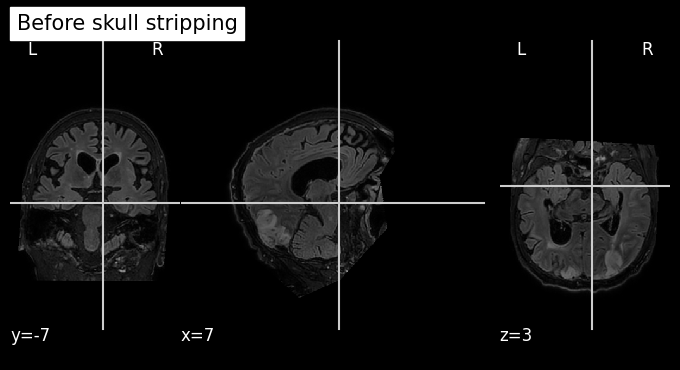

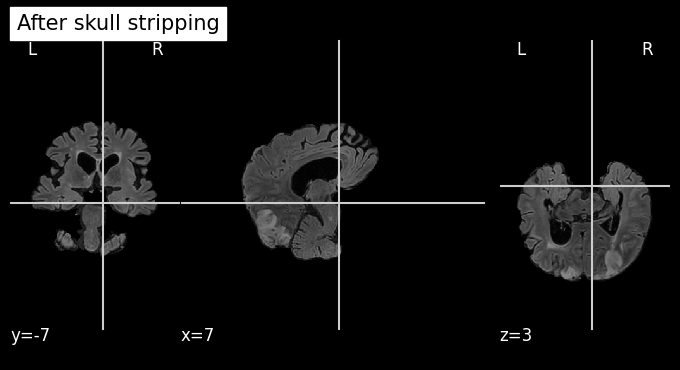

In [16]:
# Comparing the MRI image before and after skull stripping
plot_anat(os.path.join(r"sub-2/anat/", 'sub-2_FLAIR.nii.gz'),
          cut_coords=(7,-7,3), 
          title='Before skull stripping')


plot_anat(os.path.join("sub-2/anat/", 'flair_2.nii.gz'),
          cut_coords=(7,-7,3),
          title='After skull stripping')

### Data Transformation and Save file as numpy array

In [5]:
import gc
import glob
import os
import subprocess
import numpy as np
from scipy.ndimage import zoom

# Resampling function to resize the array to the target shape
def resample_array(array, target_shape):
    zoom_factors = [float(t) / float(s) for t, s in zip(target_shape, array.shape)]
    resampled_array = zoom(array, zoom_factors, order=1)  # Order=1 for bilinear interpolation
    return resampled_array

# Skull stripping function with error handling
def skull_cut(file_path, output_name, number):
    try:
        struc = fsl.data.image.Image(file_path)
        bet_struc = bet(struc, output=output_name, mask=True)
        print(f"Skull stripping complete for sub-{number}")
    except Exception as e:
        print(f"Error in skull stripping for sub-{number}: {e}")

# Function to register FLAIR image to MNI space using FLIRT
def register_to_mni(flair_file, sub_id, output_registered_file):
    # Define the MNI template path
    mni_template = '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'

    try:
        # Run flirt to register the skull-stripped flair image to MNI space
        subprocess.run([
            'flirt',
            '-in', flair_file,
            '-ref', mni_template,
            '-out', output_registered_file,
            '-omat', f'sub-{sub_id}/anat/flair_{sub_id}_to_mni.mat',
            '-dof', '12'
        ], check=True)
        print(f"Registration complete for sub-{sub_id}")
        
        # Check if the registered file was created
        if not os.path.exists(output_registered_file):
            print(f"Error: Registered file {output_registered_file} was not created.")
            return False
        return True

    except Exception as e:
        print(f"Error in registration for sub-{sub_id}: {e}")
        return False

# Function to find the lesion mask file with variable names
def find_lesion_mask(sub_id):
    lesion_mask_pattern = f"derivatives/lesion_masks/sub-{sub_id}/dwi/sub-{sub_id}_space-TRACE_desc-lesion*_mask.nii.gz"
    lesion_files = glob.glob(lesion_mask_pattern)
    
    if lesion_files:
        return lesion_files[0]
    return None

# Function to save individual subject data to a .npz file
def save_individual_subject(flair_data, label, sub_id, save_path):
    save_file_path = os.path.join(save_path, f'sub-{sub_id}.npz')
    try:
        np.savez(save_file_path, flair=flair_data, label=label)
        print(f"Saved sub-{sub_id} data to {save_file_path}")
    except Exception as e:
        print(f"Error saving sub-{sub_id} data: {e}")

# Preprocessing function to save each subject's data to an individual .npz file
def preprocess_data(num_folder, target_shape, save_path):
    for i in range(1, num_folder+1):
        # Check if the .npz file for this subject already exists and skip processing if found
        save_file_path = os.path.join(save_path, f'sub-{i}.npz')
        if os.path.exists(save_file_path):
            print(f"File {save_file_path} already exists. Skipping sub-{i}.")
            continue  # Skip this subject as it's already processed

        train_file_path = f"sub-{i}/anat/sub-{i}_FLAIR.nii.gz"
        
        # Check if the FLAIR file exists
        if not os.path.exists(train_file_path):
            print(f"File {train_file_path} does not exist. Skipping sub-{i}.")
            continue

        # Perform skull stripping first
        skull_stripped_file = f"sub-{i}/anat/sub-{i}_FLAIR_skull_stripped.nii.gz"
        skull_stripped_mask_file = f"sub-{i}/anat/sub-{i}_FLAIR_skull_stripped_mask.nii.gz"
        skull_cut(train_file_path, skull_stripped_file, i)

        # Register skull-stripped FLAIR to MNI space and verify
        registered_file = f"sub-{i}/anat/sub-{i}_FLAIR_registered.nii.gz"
        if not register_to_mni(skull_stripped_file, i, registered_file):
            print(f"Skipping sub-{i} due to registration failure.")
            continue
        
        # Load and normalize the FLAIR data
        try:
            data = nib.load(registered_file).get_fdata()
            flair_data = resample_array(data, target_shape)
            flair_data = (flair_data - flair_data.min()) / (flair_data.max() - flair_data.min())
        except Exception as e:
            print(f"Error loading/normalizing FLAIR data for sub-{i}: {e}")
            continue
        
        # Check for lesion mask
        lesion_mask_file = find_lesion_mask(i)
        if lesion_mask_file:
            try:
                lesion_label = nib.load(lesion_mask_file).get_fdata()
                label = 1
            except Exception as e:
                print(f"Error loading lesion mask for sub-{i}: {e}")
                label = 0
        else:
            label = 0
        
        # Save individual subject data to .npz file
        save_individual_subject(flair_data, label, i, save_path)

        # Clean up intermediate files to free memory
        try:
            os.remove(skull_stripped_file)
            os.remove(skull_stripped_mask_file)  # Remove skull-stripped mask file
            os.remove(registered_file)
            os.remove(f"sub-{i}/anat/flair_{i}_to_mni.mat")  # Remove FLIRT matrix file
        except Exception as e:
            print(f"Error removing files for sub-{i}: {e}")
        
        # Free memory for loaded data
        del data, flair_data
        gc.collect()

# Example usage: preprocess 1737 subjects, save each as an individual .npz file to an external hard disk
external_save_path = r'E:\MRI_project'  # Ensure correct path, using raw string or backslashes
preprocess_data(num_folder=1737, target_shape=(64, 64, 64), save_path=external_save_path)


File E:\MRI_project/sub-1.npz already exists. Skipping sub-1.
File E:\MRI_project/sub-2.npz already exists. Skipping sub-2.
File E:\MRI_project/sub-3.npz already exists. Skipping sub-3.
File E:\MRI_project/sub-4.npz already exists. Skipping sub-4.
File E:\MRI_project/sub-5.npz already exists. Skipping sub-5.
File E:\MRI_project/sub-6.npz already exists. Skipping sub-6.
File E:\MRI_project/sub-7.npz already exists. Skipping sub-7.
File E:\MRI_project/sub-8.npz already exists. Skipping sub-8.
File E:\MRI_project/sub-9.npz already exists. Skipping sub-9.
File E:\MRI_project/sub-10.npz already exists. Skipping sub-10.
File E:\MRI_project/sub-11.npz already exists. Skipping sub-11.
File E:\MRI_project/sub-12.npz already exists. Skipping sub-12.
File E:\MRI_project/sub-13.npz already exists. Skipping sub-13.
File E:\MRI_project/sub-14.npz already exists. Skipping sub-14.
File E:\MRI_project/sub-15.npz already exists. Skipping sub-15.
File E:\MRI_project/sub-16.npz already exists. Skipping su